## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [3]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [4]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
283386,786728,11322,58,578,11.0
915385,635875,13865,92,11436,100.0
3547324,224613,9342,130,21725,100.0
4996435,401704,3734,133,5428,100.0
1459469,544899,3734,108,5967,100.0


Сделаем разбиение по времени

<Axes: >

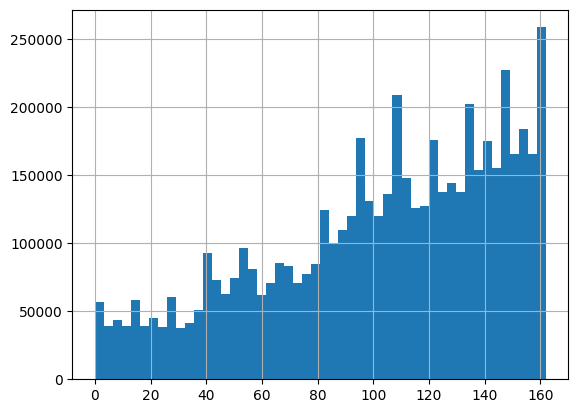

In [5]:
df.last_watch_dt.hist(bins=50)

In [6]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [7]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [8]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [9]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
78,94135,1819,20,802,12.0
121,538575,11332,98,71721,100.0
144,196855,11754,148,86,1.0
160,59968,3734,146,9445,100.0
189,969875,372,122,567,12.0


In [10]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_65623/1105526701.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_65623/1105526701.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,47,"[(13361, 138), (13865, 138), (7401, 142), (129..."
1,229,"[(11275, 110), (4151, 110), (1699, 126), (1460..."
2,313,"[(14170, 4), (162, 4), (8276, 6), (758, 14), (..."
3,446,"[(13865, 105)]"
4,480,"[(7389, 51), (9314, 51), (760, 55), (9709, 56)..."


In [11]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]"
1,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]"
2,313,"[(14170, 4), (162, 4), (8276, 6), (758, 14), (...","[(9062, 156)]"
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]"
4,480,"[(7389, 51), (9314, 51), (760, 55), (9709, 56)...","[(7025, 161)]"


In [12]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]","[8002, 1660, 4942]"
1,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]","[8002, 1660, 4942]"
2,313,"[(14170, 4), (162, 4), (8276, 6), (758, 14), (...","[(9062, 156)]","[8002, 1660, 4942]"
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[8002, 1660, 4942]"
4,480,"[(7389, 51), (9314, 51), (760, 55), (9709, 56)...","[(7025, 161)]","[8002, 1660, 4942]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$. 

In [17]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    y = np.isin(predictions, gt_items)
    p = y.cumsum() / np.arange(1, len(y) + 1)
    return (p * y).sum() / min(topn, len(gt_items))

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    y = np.isin(predictions, gt_items)
    inds = np.where(y == 1)[0]
    if inds.size == 0:
        return 0
    return 1 / (inds[0] + 1)

def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    y = np.isin(predictions, gt_items)
    return y.sum() > 0


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [18]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [19]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [20]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0010777777777777778, 'mrr': 0.002533333333333333, 'hr': 0.0027}

In [21]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]","[8002, 1660, 4942]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]","[8002, 1660, 4942]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,313,"[(14170, 4), (162, 4), (8276, 6), (758, 14), (...","[(9062, 156)]","[8002, 1660, 4942]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[8002, 1660, 4942]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,480,"[(7389, 51), (9314, 51), (760, 55), (9709, 56)...","[(7025, 161)]","[8002, 1660, 4942]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [22]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06583593143738976, 'mrr': 0.11511388888888889, 'hr': 0.2746}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [23]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        counts = {}
        for _, row in df.iterrows():
            for item, time in row[col]:
                if time >= 160 - 7 - self.min_window:
                    if item in counts:
                        counts[item] += 1
                    else:
                        counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна. 

In [28]:
maps = []
mrrs = []
hrs = []
for min_window in range(1, 150):
    toppop = TopPopularWeighted(min_window=min_window)
    toppop.fit(joined)

    joined['toppopularweighted_recs'] = toppop.predict(joined)
    mets = evaluate_recommender(joined, model_preds='toppopularweighted_recs')
    maps.append(mets['map'])
    mrrs.append(mets['mrr'])
    hrs.append(mets['hr'])

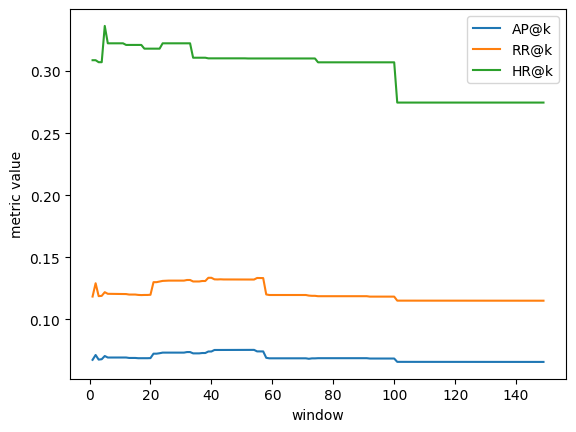

In [29]:
plt.plot(list(range(1, 150)), maps)
plt.plot(list(range(1, 150)), mrrs)
plt.plot(list(range(1, 150)), hrs)
plt.xlabel('window')
plt.ylabel('metric value')
plt.legend(['AP@k', 'RR@k', 'HR@k'])
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** На графике виден общий тренд того, что сначала при небольшом росте окна качество возрастает, а потом, при дальнейшем увеличении окна оно начинает падать. Это в целом отражает наше представление о том, как должны выглядеть рекомендации по популярным айтемам - не использовать те, что были популярны давно (в контексте нашего датасета свыше 60 дней назад), но также брать не только те, что популярны в последние несколько дней. Оптимальным значением, сюдя по графику, будет окно в районе 30 дней, то есть последний месяц.

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [163]:
toppop = TopPopular()
toppop.fit(joined)
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [164]:
def evaluate_recommender_topn(df, model_preds, gt_col='test_interactions', topn=None):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions, topn)
        rr = rr_metric(gt_items, predictions, topn)
        hr = hr_metric(gt_items, predictions, topn)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

In [171]:
maps = []
mrrs = []
hrs = []
for k in range(1, 101):
    mets = evaluate_recommender_topn(joined, model_preds='toppopular_recs', topn=k)
    maps.append(mets['map'])
    mrrs.append(mets['mrr'])
    hrs.append(mets['hr'])

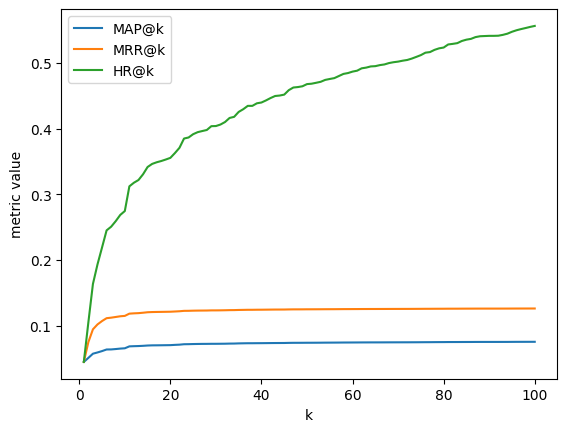

In [172]:
plt.plot(list(range(1, 101)), maps)
plt.plot(list(range(1, 101)), mrrs)
plt.plot(list(range(1, 101)), hrs)
plt.xlabel('k')
plt.ylabel('metric value')
plt.legend(['MAP@k', 'MRR@k', 'HR@k'])
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:** MRR@k и HR@k являются монотонными по определению, а MAP@k таковой не является, но ее график все же является монотонным: 
1) Для MAP@k - чем больше k, тем в среднем будет больше значение метрики, потому что если релевантные айтемы оказались не в начале, а top-K маленькое, то значение метрики будет 0. Поэтому увеличивая k, мы в среднем увеличиваем значение метрики. Да, оно может для конкретного случая и уменьшиться (например первые два айтема были релевантными, а дальше нет, т.е. сначала значение AP@k было 1, а потом стало уменьшаться при увеличении k), но так как таких случаев меньше, то в среднем значение метрики монотонно возрастает. 

2) Для MRR@k - монотонная по формуле, с увеличением k значение метрики может только увеличиваться. Не может быть такого, что релевантный элемент среди каких-то первых k айтемов был и значение метрики было больше 0, а среди k+1 первых айтемов его не будет и значение будет 0. Так же не может увеличиваться номер первого релевантного айтема.

3) Для HR@k - практически аналогично предыдущему. Функция монотонно возрастает всегда. Если среди первых k айтемов есть хотя бы один релевантный, то при k+1 он тоже будет.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:** 
1) Для MAP@k - если мы говорим про сценарий со скроллингом ленты, то тогда ее график отражает процент того, насколько релевантными оказались рекомендации в зависимости от того, сколько постов пользователь посмотрел в ленте. В среднем для всех пользователей, если они смотрят больше постов, то среди них будет больше релевантных

2) Для MRR@k - график показывает, когда в среднем по всем пользователям им попадается первый релевантный пост, и чем больше постов в ленте они посмотрят, тем больше шанс, что этот первый пост будет среди просмотренных

3) Для HR@k - график показывает какой части пользователей попался в ленте хотя бы один релевантный пост в зависимости от количества просмотренных

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**
В случае MRR@k и HR@k графики выглядят так, как от них и ожидается, они монотонно возрастают по k так как это задано по определению и не зависит от внешних факторов. Они не будут возрастать только если среди рекомендаций вообще не будет релевантных и тогда метрики будут константным 0, но убывать они все так же не будут. В случае с MAP@k варианты могут быть разными. Рассмотрим крайние случаи - например, все релевантные айтемы находятся в конце предложенных рекомендаций, тогда график метрики будет возрастать, причем он будет 0 до момента появления первого релевантного айтема и потом начнет расти. В противоположном случае, когда релевантные айтемы находятся в начале предложенных рекомендаций, а за ними идут нерелевантные - тогда график наоборот будет убывать, в начале он будет 1 до момоента появления первого нерелевантного айтема и дальше начнет убывать. В нашем случае я предполагаю, что случаев, похожих на первый пример в нашей модели больше, поэтому график возрастающий, но не всегда это может быть так 

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей. 

In [33]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

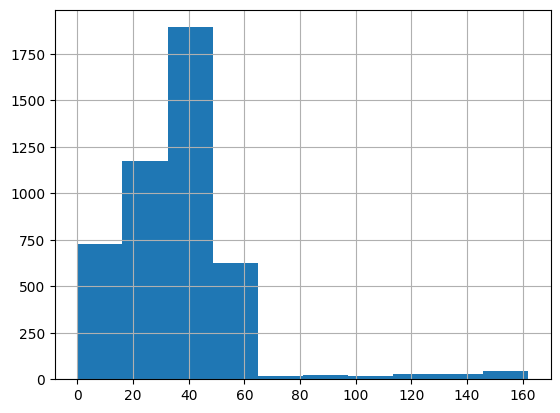

In [34]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Добавьте 5 своих примеров ниже. Опишите, как вы их искали. 

Я искал примеры просто через random_choice как в ячейке выше и смотрел на графики

В поисках Дори


<Axes: >

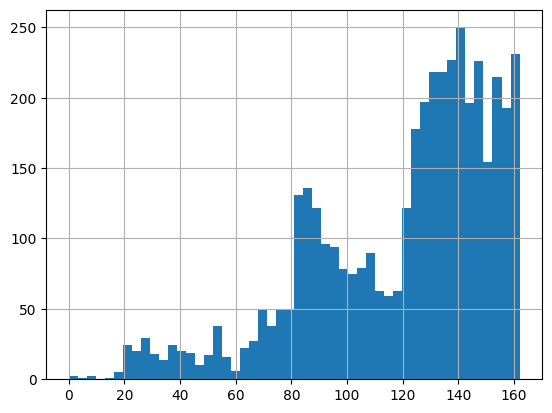

In [45]:
sampled_id = 10605
interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist(bins=50)

По гистограмме видно, что сначала фильм не пользовался особой популярностью, потом в начале лета произошел скачок популярности, дальше небольшой спад и после середины лета снова произошел резкий скачок популярности. Возможно это связано с тем, что это мультфильм и летом, когда у детей каникулы, его смотрели больше, а также сам мультфильм про море и летнюю тематику, поэтому возможно из-за этого он показывал скачки именно летом.

Убийство онлайн


<Axes: >

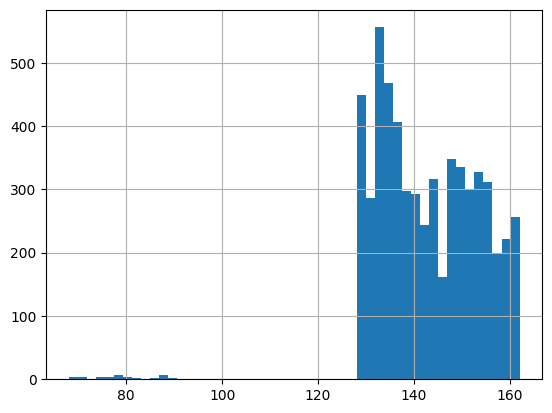

In [52]:
sampled_id = 14899
interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist(bins=50)

На графике видно, что до июля практически никто не взаимодейстовал с этим фильмом на платформе, но потом произошел резкий скачок в популярности. Скорее всего это связано с тем, что фильм вышел в этом же году и цифровой релиз состоялся в конце мая. Возможно до июля платформа не имела лицензии на фильм, но потом ее приобрела и появилась возможность посмотреть этот фильм на сервисе

Марсианин


<Axes: >

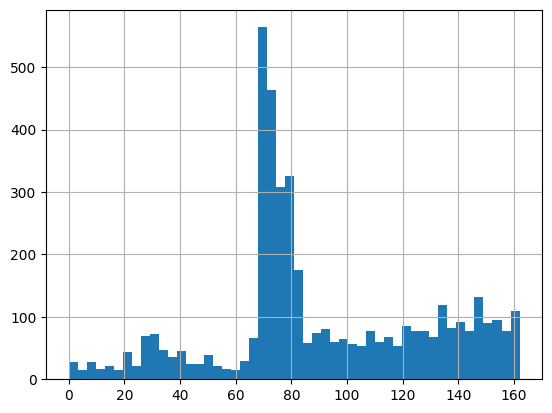

In [53]:
sampled_id = 2301
interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist(bins=50)

На графике видно, что до конца мая фильм не пользовался особой популярностью, потом произошел резкий скачок и такой же резкий спад, но после спада средняя популярность немного увеличилась по сравнению с периодом перед скачком. Возмжно это связано с частыми упоминаниями этого фильма в социальных сетях в промежуток времени, когда произошел скачок, но с резким спадом тренда на этот фильм в социальных сетях также упали и просмотры.

Криминальные боссы


<Axes: >

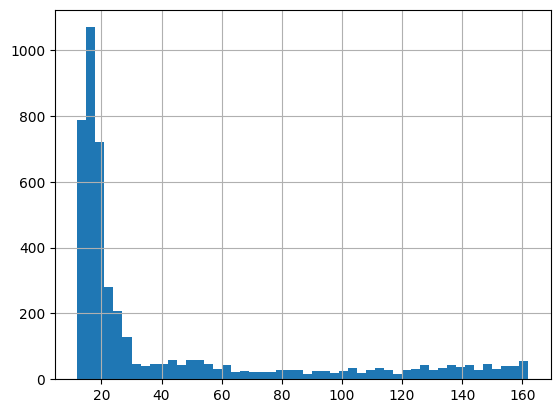

In [55]:
sampled_id = 1053
interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist(bins=50)

На этом графике видно, что сначала, в марте фильм был популярным, но потом популярность пошла на резкий спад. Скорее всего это связано с тем, что цифровой релиз фильма состоялся в конце декабря, в марте он появился на платформе и много людей его сразу посмотрело, но дальше он уже непользовался популярностью у зрителей, потому что возможно оказался плохого качества

Ford против Ferrari


<Axes: >

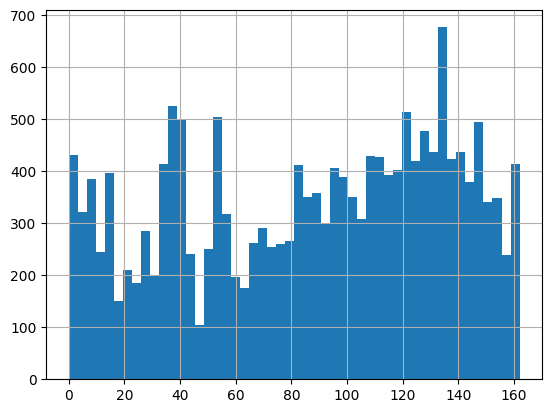

In [59]:
sampled_id = 4436
interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist(bins=50)

По графику видно, что этот фильм особо не имел больших скачков в популярности, он был популярен практически все время, представленное в данных. Возможно это связано с тем, что фильм был качественным, с высоким рейтингом и пользователи могли даже его пересматривать, потому что фильм вышел за два года до дат, показываемых на графике, но все равно имел популярность на сервисе, причем постоянную

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках. 

In [158]:
def filter_column(df, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    df_c = df.copy()
    while True:
        change = False
        users_activity = df_c.groupby(['user_id']).count().sort_values('item_id')
        needed_inds = users_activity[users_activity['item_id'] >= min_freq].index.tolist()
        df_c = df_c[np.isin(df_c['user_id'], needed_inds)]

        items_activity = df_c.groupby(['item_id']).count().sort_values('user_id')
        if items_activity['user_id'].tolist() and items_activity['user_id'].tolist()[0] < min_freq:
            change = True
        needed_inds = items_activity[items_activity['user_id'] >= min_freq].index.tolist()
        df_c = df_c[np.isin(df_c['item_id'], needed_inds)]
        if not change:
            break
        
    return df_c

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    return filter_column(df, min_freq) # Я в целом весь нужный функционал для нашей задачи написал в первой функции, так что я только ей пользовался

filtered_train = filter_column(train_df, 5)

In [159]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df, user2id, item2id, id2item, id2user

filtered_train, user2id, item2id, id2item, id2user = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
72532,919,798,92,612,13.0
1661711,5605,348,110,5485,100.0
3007086,1667,14,86,1282,13.0
1708972,206,425,89,149,3.0
2400440,3912,66,91,23243,100.0


In [160]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<5853x3074 sparse matrix of type '<class 'numpy.float64'>'
	with 106096 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

In [149]:
users_counts = []
items_counts = []
for min_freq in range(31):
    fil_t = filter_column(train_df, min_freq)
    users_counts.append(fil_t.user_id.nunique())
    items_counts.append(fil_t.item_id.nunique())

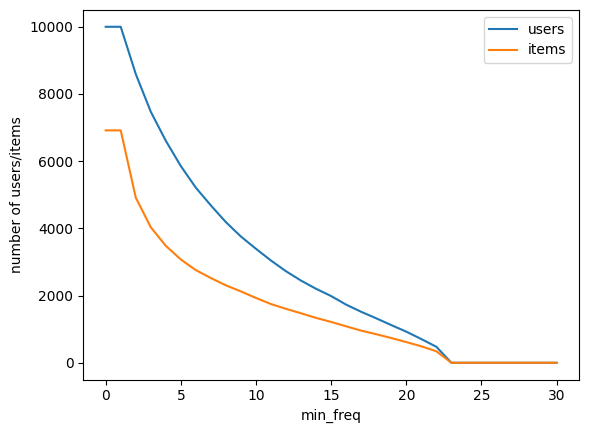

In [187]:
plt.plot(list(range(31)), users_counts)
plt.plot(list(range(31)), items_counts)
plt.xlabel('min_freq')
plt.ylabel('number of users/items')
plt.legend(['users', 'items'])
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [161]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=1000):
    # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

w = fit_ease(matrix)

CPU times: user 4.35 s, sys: 238 ms, total: 4.59 s
Wall time: 780 ms


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [162]:
def get_preds(x, item2id, id2item):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]
    preds[encoded==1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:100]
    
    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopularweighted_recs,ease_preds
0,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]","[8002, 1660, 4942]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 3734, 15297, 12995, 8636, 4880, ..."
1,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]","[8002, 1660, 4942]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[4151, 4880, 3734, 10440, 15297, 142, 2657, 13..."
2,313,"[(14170, 4), (162, 4), (8276, 6), (758, 14), (...","[(9062, 156)]","[8002, 1660, 4942]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[4151, 10440, 3734, 9728, 13865, 142, 16228, 2..."
3,446,"[(13865, 105)]","[(12202, 160), (230, 160)]","[8002, 1660, 4942]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 3734, 15297, 12995, 4880, 8636, ..."
4,480,"[(7389, 51), (9314, 51), (760, 55), (9709, 56)...","[(7025, 161)]","[8002, 1660, 4942]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[10440, 15297, 9728, 3734, 13865, 4880, 2657, ..."


In [173]:
maps_ease = []
mrrs_ease = []
hrs_ease = []
for k in range(1, 101):
    mets = evaluate_recommender_topn(joined, model_preds='ease_preds', topn=k)
    maps_ease.append(mets['map'])
    mrrs_ease.append(mets['mrr'])
    hrs_ease.append(mets['hr'])

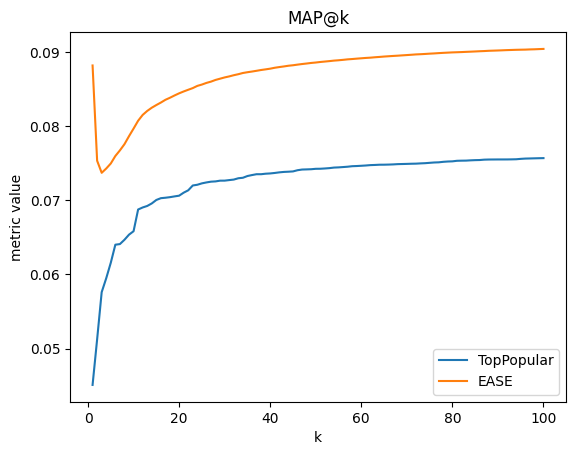

In [175]:
plt.plot(list(range(1, 101)), maps)
plt.plot(list(range(1, 101)), maps_ease)
plt.xlabel('k')
plt.ylabel('metric value')
plt.legend(['TopPopular', 'EASE'])
plt.title('MAP@k')
plt.show()

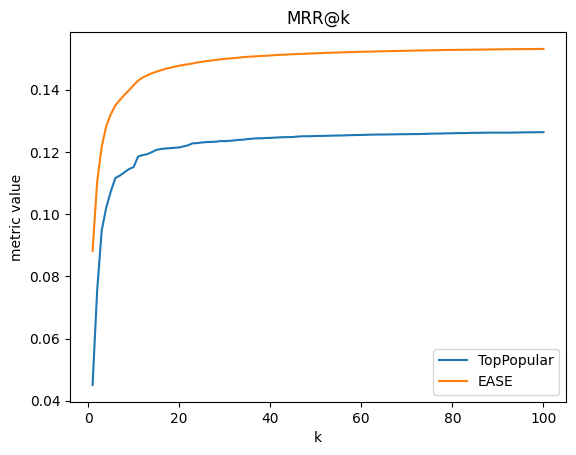

In [176]:
plt.plot(list(range(1, 101)), mrrs)
plt.plot(list(range(1, 101)), mrrs_ease)
plt.xlabel('k')
plt.ylabel('metric value')
plt.legend(['TopPopular', 'EASE'])
plt.title('MRR@k')
plt.show()

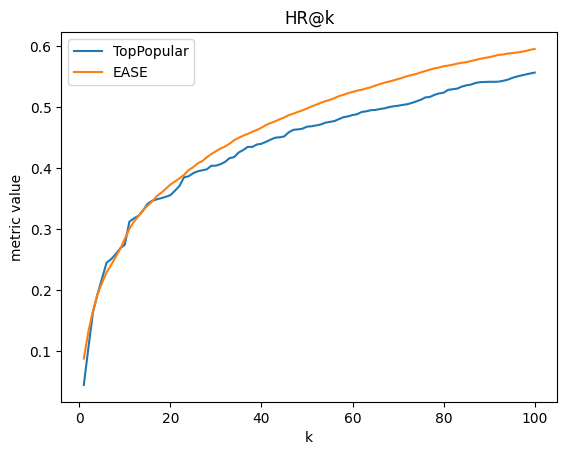

In [177]:
plt.plot(list(range(1, 101)), hrs)
plt.plot(list(range(1, 101)), hrs_ease)
plt.xlabel('k')
plt.ylabel('metric value')
plt.legend(['TopPopular', 'EASE'])
plt.title('HR@k')
plt.show()

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:** По получившимся графикам видно, что по каждой метрике алгоритм EASE работает лучше и дает лучшее качество для всех k

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации. 

In [185]:
weights = np.logspace(2, 3.5, 20)
maps_ease_2 = []
mrrs_ease_2 = []
hrs_ease_2 = []
for weight in weights:
    w = fit_ease(matrix, reg_weight=weight)
    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
    mets = evaluate_recommender(joined, model_preds='ease_preds')
    maps_ease_2.append(mets['map'])
    mrrs_ease_2.append(mets['mrr'])
    hrs_ease_2.append(mets['hr'])

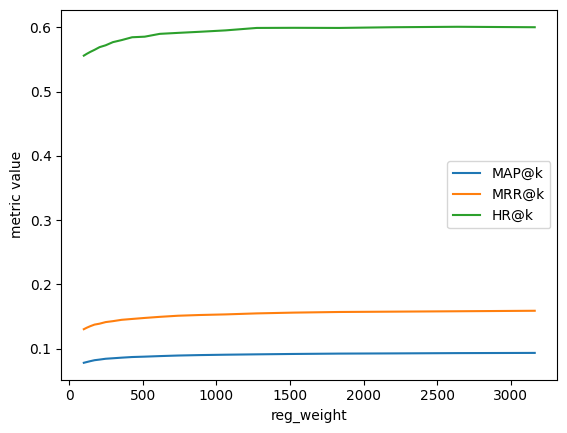

In [186]:
plt.plot(list(weights), maps_ease_2)
plt.plot(list(weights), mrrs_ease_2)
plt.plot(list(weights), hrs_ease_2)
plt.xlabel('reg_weight')
plt.ylabel('metric value')
plt.legend(['MAP@k', 'MRR@k', 'HR@k'])
plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим? 


**Ответ:** Графики не очень сильно растут, но примерно при параметре = 2000 они выходят на плато и качество перестает увеличиваться, так что наилучшим параметром будет примерно 2000

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:** По графикам видно, что параметр влияет на разные метрики практически одинаково, видно небольшой прирост (но самый быстрый) в начале, когда параметр растет до 500, потом рост каждой функции становится более равномерным и в дальнейшем выходит на плато. Скорость тюнинга довольно маленькая - чем большие значения параметра мы берем, тем медленнее растут метрики

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы. 

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_65623/2440695216.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped_local = fil_t.groupby('user_id').apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda x: x[1])]).reset_index()
/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_65623/2440695216.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

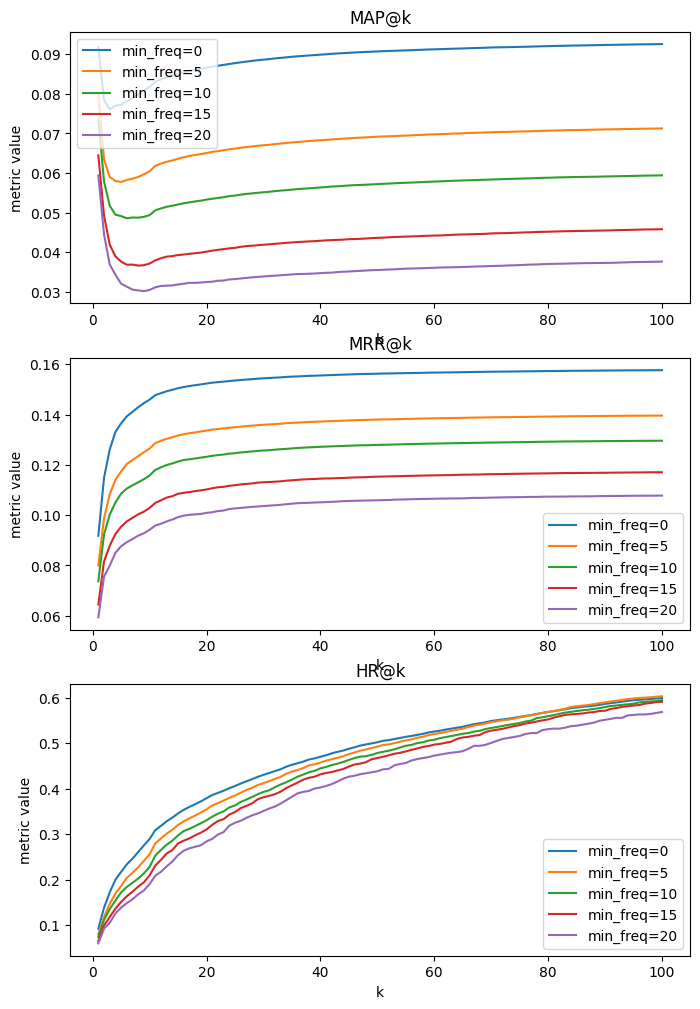

In [327]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].set_title('MAP@k')
axs[1].set_title('MRR@k')
axs[2].set_title('HR@k')

axs[0].set_xlabel('k')
axs[1].set_xlabel('k')
axs[2].set_xlabel('k')

axs[0].set_ylabel('metric value')
axs[1].set_ylabel('metric value')
axs[2].set_ylabel('metric value')

for min_freq in range(0, 21, 5):
    maps = []
    mrrs = []
    hrs = []
    fil_t = filter_column(train_df, min_freq)
    train_grouped_local = fil_t.groupby('user_id').apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda x: x[1])]).reset_index()
    train_grouped_local.rename({0:'train_interactions'}, axis=1, inplace=True)
    joined_local = train_grouped_local.merge(test_grouped)
    joined_local['ease_preds'] = joined_local.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
    for k in range(1, 101):
        mets = evaluate_recommender_topn(joined_local, model_preds='ease_preds', topn=k)
        maps.append(mets['map'])
        mrrs.append(mets['mrr'])
        hrs.append(mets['hr'])
    axs[0].plot(list(range(1, 101)), maps)
    axs[1].plot(list(range(1, 101)), mrrs)
    axs[2].plot(list(range(1, 101)), hrs)
axs[0].legend([f"min_freq={mf}" for mf in range(0, 21, 5)])
axs[1].legend([f"min_freq={mf}" for mf in range(0, 21, 5)])
axs[2].legend([f"min_freq={mf}" for mf in range(0, 21, 5)])
plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:** Получилось то, что мы и ожидали - чем больше было значение фильтра, тем хуже EASE показвало качество. Можно заметить, как кривая для MAP@k достигала все меньших значений (при min_freq = 0 была чуть меньше 0.1 и к min_freq = 20 упала ниже 0.04). Аналогичная ситуация просматривается и для кривой MRR@k - изначально она выходила на плато примено на уровне 0.16, к min_freq = 20 стала выходить на плато на уровне 0.1. Для HR@k тоже видно, что сначала кривая достигала значения 0.6 при увеличении k, к min_freq = 20 перестала достигать. Так что кривые всех метрик подтвердили начальное утверждение

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций. 

In [224]:
w = fit_ease(matrix, reg_weight=2000)

In [292]:
def get_recs(item, item2id, id2item):
    print(f"Топ-5 рекомендаций для фильма {items.loc[items.item_id==item].title.values[0]}:\n")
    id = item2id[item]
    ranks = np.array(np.argsort(w[:, id].reshape(3074,)))[0][-5:][::-1]
    decoded = [id2item[t] for t in ranks]
    for i, film_id in enumerate(decoded):
        print(f"{i + 1}. {items.loc[items.item_id==film_id].title.values[0]}\n")

In [294]:
get_recs(10605, item2id, id2item)

Топ-5 рекомендаций для фильма В поисках Дори:

1. 100% волк

2. Вперёд

3. Зверополис

4. Ральф против Интернета

5. Суперсемейка 2



Все рекомендации - это мультфильмы, а первые три - про животных (или похожих на них созданий), как и сам айтем. Так что тут рекомендации хорошие

In [295]:
get_recs(2301, item2id, id2item)

Топ-5 рекомендаций для фильма Марсианин:

1. 2067: Петля времени

2. Перл Харбор

3. Послезавтра

4. Белый снег

5. Назад в будущее



Тут немного смешанные получились рекомендации. Первая и третья подходят под тематику айтема, а последняя под жанр научной фантастики, но вторая и четвертая как-то плохо ассоциируются с айтемом

In [296]:
get_recs(4436, item2id, id2item)

Топ-5 рекомендаций для фильма Ford против Ferrari:

1. Гнев человеческий

2. Веном

3. Зелёная книга

4. Белый снег

5. Девятаев



Тут именно по тематике айтема плохо подобрались рекомендации, ни одной рекомендации с фильмом про гонки, а первые три просто популярные хорошие фильмы. Возможно, это потому что других фильмов про гонки на платформе не было и, наверное, потому что айтем является довольно популярным фильмом и вместе с ним пользователи смотрели другие популярные фильмы, но не схожие по тематике, т.е. не обязательно те, кто посмотрел этот фильм интересовались гонками и другими фильмами на эту тематику, они просто решили посмотреть высокорейтинговый фильм, который в то же время популярный

In [298]:
get_recs(3402, item2id, id2item)

Топ-5 рекомендаций для фильма 1917:

1. Doom: Аннигиляция

2. Восемь сотен

3. Аферистка

4. Во всё тяжкое

5. Сплит



Первые две рекомендации более-менее хорошие (мне кажется 2 даже лучше), остальные не очень

In [302]:
get_recs(12770, item2id, id2item)

Топ-5 рекомендаций для фильма Соседи сверху:

1. Секс и ничего лишнего

2. Секса много не бывает

3. Клиника счастья

4. Молодость

5. Простые сложности



Ну тут под тематику все подходит) - рекомендации хорошие

In [307]:
get_recs(9842, item2id, id2item)

Топ-5 рекомендаций для фильма Невидимый гость:

1. Между нами горы

2. Убийство в Восточном экспрессе

3. Хрустальный

4. Взаперти

5. Королевский Гамбит



Для детектива-триллера получились хорошие рекомендации

In [312]:
get_recs(8254, item2id, id2item)

Топ-5 рекомендаций для фильма В поисках Немо:

1. Зверополис

2. Корпорация монстров

3. Тачки

4. В поисках Дори

5. Рататуй



Даже все пиксаровские мультфильмы порекоммендовал (и в поисках дори в том числе)

In [319]:
get_recs(366, item2id, id2item)

Топ-5 рекомендаций для фильма Послезавтра:

1. Веном

2. 2067: Петля времени

3. Алита: Боевой ангел

4. Гнев человеческий

5. Kingsman: Секретная служба



Для фильма катастрофы не очень хорошие рекоммендации

In [324]:
get_recs(6809, item2id, id2item)

Топ-5 рекомендаций для фильма Дуров:

1. Клиника счастья

2. Сахаров. Две жизни

3. Гнев человеческий

4. Секреты семейной жизни

5. Девятаев



Тоже так себе - только один документальный фильм в рекомендациях, остальные даже по тематике не очень схожи

In [326]:
get_recs(7310, item2id, id2item)

Топ-5 рекомендаций для фильма Гадкий я 2:

1. Миньоны

2. Гадкий я

3. 100% волк

4. Ральф против Интернета

5. Суперсемейка 2



Ну тут прямо хорошие попадания в первые два, остальные тоже мультфильмы, тоже хорошо

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:** В целом рекомендации получились довольно хорошие для большинства айтемов. Особенно хорошо себя показали мультфильмы, на которых выдавались чуть ли не самые релевантные из возможных вариантов. Скорее всего это связано с тем, что мультфильмы обычно смотрят дети и если они пользуются платформой со своего аккаунта, то в просмотренных фильмах будут только мультфильмы и скорее всего довольно похожие друг на друга. Плохие примеры тоже есть и я предполагаю, что это может быть связано с тем, что: 

1) Недостаточно похожих фильмов на платформе
2) Высокорейтинговые популярные фильмы смотрят скорее не за жанр и тематику, а как раз за принадлежность к таковым и поэтому для них в рекомендациях могут попадаться другие высокорейтинговые популярные фильмы, но совсем не связанные общей темой
3) Для совсем непопулярных фильмов возможно не хватает данных от пользователей и для них трудно подобрать релевантные рекоммендации